In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob

LOCAL_PATH = os.getcwd()
print(os.listdir(LOCAL_PATH))
sys.path.append(LOCAL_PATH)
sys.path.append(LOCAL_PATH + '/lib')

IMG_PATH = LOCAL_PATH + '/img/'

import time
os.environ["TZ"] = "US/Eastern"
time.tzset()

['.DS_Store', 'img', '.gitignore', 'lib', '.ipynb_checkpoints', 'extract-features-vgg19.ipynb', '.git']


In [3]:
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

In [4]:
all_image_paths = list_files(IMG_PATH)
all_image_paths.sort()
all_image_paths

['/Users/angelaradulescu/Dropbox/NYU/Research/image-embed/img/Face(1).png',
 '/Users/angelaradulescu/Dropbox/NYU/Research/image-embed/img/Face(2).png',
 '/Users/angelaradulescu/Dropbox/NYU/Research/image-embed/img/Face(3).png',
 '/Users/angelaradulescu/Dropbox/NYU/Research/image-embed/img/House(1).png',
 '/Users/angelaradulescu/Dropbox/NYU/Research/image-embed/img/House(2).png',
 '/Users/angelaradulescu/Dropbox/NYU/Research/image-embed/img/House(3).png',
 '/Users/angelaradulescu/Dropbox/NYU/Research/image-embed/img/Tool(1).png',
 '/Users/angelaradulescu/Dropbox/NYU/Research/image-embed/img/Tool(2).png',
 '/Users/angelaradulescu/Dropbox/NYU/Research/image-embed/img/Tool(3).png']

In [5]:
import torch
import torch.nn as nn
from ExtractFeatures import VGG19Embeddings

import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logsumexp

import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as f

from PIL import Image

use_cuda = torch.cuda.is_available()

In [6]:
def RGBA2RGB(image, color=(255, 255, 255)):
            """Alpha composite an RGBA Image with a specified color.
            Simpler, faster version than the solutions above.
            Source: http://stackoverflow.com/a/9459208/284318
            Keyword Arguments:
            image -- PIL RGBA Image object
            color -- Tuple r, g, b (default 255, 255, 255)
            """
            image.load()  # needed for split()
            
            # Check if we have alpha channel.
            if len(image.split()) == 4: 
                background = Image.new('RGB', image.size, color)
                background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
            else: 
                background = image
            return background

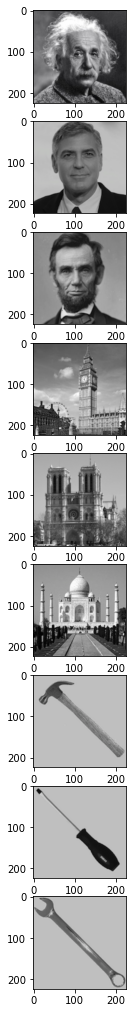

In [7]:
batch_size = len(all_image_paths)
imsize = 224
padding = 0

# Initialize batch tensor.
im_batch = torch.zeros(batch_size, 3, imsize, imsize)

# Make plot for visualizing dataset. 
fig, ax = plt.subplots(batch_size, 1, figsize=(9,18))

# Define normalization.
normalize = transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225))

# Load each image.
for i in np.arange(batch_size):

    im = RGBA2RGB(Image.open(all_image_paths[i]))

    # Note: ToTensor implicitly divides by 255.
    loader = transforms.Compose([
                    transforms.Pad(padding),                
                    transforms.Resize(imsize),
                    transforms.ToTensor()])

    im_tensor = loader(im)
    im_tensor_norm = normalize(im_tensor)
    
    if use_cuda:
        im_tensor = im_tensor.cuda(self.cuda_device)

    # Visualize unnormalized image.
    ax[i].imshow(im_tensor.permute(1, 2, 0));

    im_batch[i,:,:,:] = im_tensor_norm.float()

In [8]:
# Load VGG19 model.
vgg19 = models.vgg19(pretrained=True)
vgg19 = VGG19Embeddings(vgg19,layer_index=6)
vgg19.eval()  # freeze dropout
# freeze each parameter
for p in vgg19.parameters():
    p.requires_grad = False
    
# Get a summary of the model architecture.
summary(vgg19, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [9]:
# Extract features.
im_features = []
for i in np.arange(batch_size):
    output = vgg19(im_batch[i,:,:,:][None, ...])
    im_features.append(output)

In [10]:
# Plot pairwise similarity as a sanity check.
pdist = nn.PairwiseDistance(p=2)

im_pairs = list(itertools.combinations(np.arange(batch_size), 2))

similarity_matrix = np.zeros((batch_size, batch_size))
for p in im_pairs:
    
    im_1_idx = p[0]
    im_2_idx = p[1]
    
    similarity_matrix[im_1_idx, im_2_idx] = pdist(im_features[im_1_idx][0], im_features[im_2_idx][0]) 
    
similarity_matrix = similarity_matrix + similarity_matrix.T

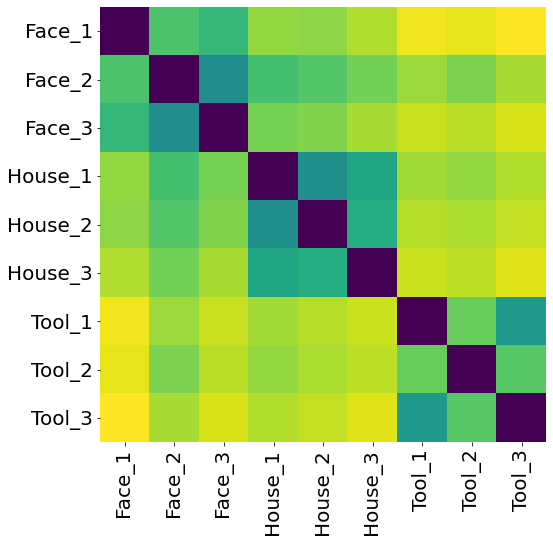

In [11]:
im_labels = ['Face_1',
             'Face_2',
             'Face_3',
             'House_1',
             'House_2',
             'House_3',
             'Tool_1',
             'Tool_2',
             'Tool_3']

fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.heatmap(similarity_matrix,cmap="viridis",cbar=False);
ax.set_xticklabels(im_labels, fontsize=20);
ax.set_yticklabels(im_labels, fontsize=20);
plt.xticks(rotation=90);
plt.yticks(rotation=0);

In [12]:
import pandas as pd

In [13]:
n_features = im_features[0][0].numpy()[0].shape[0]
print('number of features: ' + str(n_features))

number of features: 4096


In [14]:
# Make dataframe. 
embeddings ={'face_1': im_features[0][0].numpy()[0],
             'face_2': im_features[1][0].numpy()[0],
             'face_3': im_features[2][0].numpy()[0],
             'house_1': im_features[3][0].numpy()[0],
             'house_2': im_features[4][0].numpy()[0],
             'house_3': im_features[5][0].numpy()[0],
             'tool_1': im_features[6][0].numpy()[0],
             'tool_2': im_features[7][0].numpy()[0],
             'tool_3': im_features[8][0].numpy()[0]}

embeddings = pd.DataFrame.from_dict(embeddings)
embeddings.to_csv(IMG_PATH + 'embeddings.csv',index=False)

In [15]:
# Check range. 
print('min: \n' + str(embeddings.min()) + '\n\n max:\n' + str(embeddings.max()))

min: 
face_1     0.0
face_2     0.0
face_3     0.0
house_1    0.0
house_2    0.0
house_3    0.0
tool_1     0.0
tool_2     0.0
tool_3     0.0
dtype: float32

 max:
face_1     5.720988
face_2     4.246097
face_3     4.373344
house_1    3.660209
house_2    3.695072
house_3    4.345616
tool_1     4.450587
tool_2     5.114213
tool_3     6.743718
dtype: float32
